In [1]:
!pwd

/dang_van_minh_120/workspace/SpatialRGPT


In [2]:
import torch
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt # For optional visualization
import sys
from dataclasses import dataclass

# --- Configuration: Update these paths for your local machine ---
SPATIAL_RGPT_REPO_PATH = ""  # Path to your cloned SpatialRGPT repository
PROCESSED_JSONL_PATH = "PhysicalAI-Spatial-Intelligence-Warehouse/formatted_dataset/train_aicity_srgpt.jsonl" # Path to your small test JSONL
RGB_IMAGE_BASE_DIR = "PhysicalAI-Spatial-Intelligence-Warehouse/train_sample/images"
DEPTH_IMAGE_BASE_DIR = "PhysicalAI-Spatial-Intelligence-Warehouse/train_sample/depths"
# Model path for tokenizer & image_processor (can be a local path if you downloaded, or HF ID)
BASE_MODEL_PATH_FOR_CONFIG = "a8cheng/SpatialRGPT-VILA1.5-8B" 

# Add SpatialRGPT to Python path for imports
sys.path.insert(0, os.path.abspath(SPATIAL_RGPT_REPO_PATH))

try:
    from llava.train.args import DataArguments
    from llava.model.builder import load_pretrained_model
    from llava.data.dataset import LazySpatialWarehouseDataset # Your custom class
    from llava.constants import IGNORE_INDEX, DEFAULT_IMAGE_TOKEN
    from llava.mm_utils import get_model_name_from_path
    from llava.train.transformer_normalize_monkey_patch import patch_normalize_preprocess
    from llava.data import make_supervised_data_module
except ImportError as e:
    print(f"Error importing from LLaVA/SpatialRGPT. Ensure SPATIAL_RGPT_REPO_PATH is correct and it's on sys.path: {e}")
    sys.exit(1)


# Apply the normalization patch for consistency with training
patch_normalize_preprocess()
print("Applied transformers.image_transforms.normalize patch.")

# 1. Load Tokenizer and Image Processor (minimal parts of the model)
print(f"Loading tokenizer and image_processor from {BASE_MODEL_PATH_FOR_CONFIG}...")
try:
    # We only need tokenizer and image_processor, not the full model weights for this test
    # Temporarily load model just to get these, then delete model
    # Use trust_remote_code=True if the model requires it (common for VILA/LLaVA based models)
    model_path = os.path.expanduser(BASE_MODEL_PATH_FOR_CONFIG)
    model_name = get_model_name_from_path(model_path)
    tokenizer, model_temp, image_processor, _ = load_pretrained_model(
        model_path, model_name, model_base=None, 
        load_8bit=False, load_4bit=False, trust_remote_code=True 
    )

    tokenizer.pad_token = tokenizer.unk_token
    conversation_lib.default_conversation = conversation_lib.conv_templates['llama_3']
    
    del model_temp # Free up memory
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    print("Tokenizer and Image Processor loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer/image_processor from {BASE_MODEL_PATH_FOR_CONFIG}: {e}")
    print("Please ensure the model path is correct and you have an internet connection if it's a Hugging Face ID.")

/root/miniconda3/envs/spatialrgpt_finetune/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


[2025-06-04 15:32:00,545] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Applied transformers.image_transforms.normalize patch.
Loading tokenizer and image_processor from checkpoints/SpatialRGPT-VILA1.5-8B...


Loading checkpoint shards: 100%|██████████| 4/4 [00:15<00:00,  3.95s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Resuming region extractor from:  checkpoints/SpatialRGPT-VILA1.5-8B/region_extractor
Tokenizer and Image Processor loaded successfully.


In [3]:
# 2. Setup DataArguments
# Mimic DataArguments from llava.train.args or what AICityLazySpatialDataset expects
@dataclass
class MinimalDataArgs:
    def __init__(self, processor):
        self.image_processor = processor
        self.image_aspect_ratio = 'pad'  # Critical: Test with 'pad' or 'resize'
        self.is_multimodal = True
        self.mm_use_im_start_end = False # As per 3_sft.sh
        self.data_mixture = "PSIW_sft_train"
        self.depth_path = DEPTH_IMAGE_BASE_DIR
        # Add any other attributes from DataArguments your dataset class or preprocess functions use
        # self.image_grid_pinpoints = None 
        # self.use_rle_masks = True # Assuming your dataset class uses this
        # self.vflan_no_system_prompt = True # if your preprocess expects this
class TrainingArgs:
    def __init__(self):
        self.sample_lens = None
training_args = TrainingArgs()
data_args = MinimalDataArgs(image_processor)
print(data_args)

MinimalDataArgs()


In [4]:
# 3. Instantiate your AICityLazySpatialDataset
print(f"\nInstantiating AICityLazySpatialDataset with JSONL: {PROCESSED_JSONL_PATH}")
try:
    aicity_dataset = LazySpatialWarehouseDataset(
        data_path=PROCESSED_JSONL_PATH,
        image_folder=RGB_IMAGE_BASE_DIR,
        tokenizer=tokenizer,
        data_args=data_args,
        training_args=None
    )
    print("-"*100)
    print(aicity_dataset)
    print("-"*100)
    print(f"{aicity_dataset} instantiated. Number of samples: {len(aicity_dataset)}")
except Exception as e:
    print(f"ERROR instantiating AICityLazySpatialDataset: {e}")
    import traceback
    traceback.print_exc()



Instantiating AICityLazySpatialDataset with JSONL: PhysicalAI-Spatial-Intelligence-Warehouse/formatted_dataset/train_aicity_srgpt.jsonl
Spatial Warehouse Enabled
Load dataset from -> line <- json
Total SpatialWarehouse Samples  100 load from:  PhysicalAI-Spatial-Intelligence-Warehouse/formatted_dataset/train_aicity_srgpt.jsonl
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<llava.data.dataset.LazySpatialWarehouseDataset object at 0x730ab46b8880> instantiated. Number of samples: 100


In [5]:
aicity_dataset[0]

{'input_ids': tensor([128000,     32,   6369,   1990,    264,  22999,   1217,    323,    459,
          21075,  11478,  18328,     13,    578,  18328,   6835,  11190,     11,
          11944,     11,    323,  48887,  11503,    311,    279,   1217,    596,
           4860,     13,  14194,     25,    220,   -200,    198,  22818,    279,
           2561,   7710,    388,    220, 128257,    220, 128258,    220, 128257,
            220, 128258,    323,  59903,     82,    220, 128257,    220, 128258,
            220, 128257,    220, 128258,    220, 128257,    220, 128258,    220,
         128257,    220, 128258,    220, 128257,    220, 128258,    220, 128257,
            220, 128258,    220, 128257,    220, 128258,     11,    902,  59903,
            374,    279,   1888,   5873,    369,  28598,  30686,    555,    459,
           4384,  73565,     30,  36660,   3931,   2891,     25,    578,  73565,
            510,  14422,    220,     16,     60,    374,    539,  67757,    904,
          15039

In [6]:
def robust_decode_local(tokenizer, token_ids_tensor):
    """Helper to decode token IDs, replacing known problematic IDs like -200."""
    if token_ids_tensor.ndim > 1: # Handle batched tensors if they appear
        token_ids_tensor = token_ids_tensor.squeeze(0)
    
    cloned_ids = token_ids_tensor.clone().tolist() # Convert to list for easier manipulation
    
    # Replace IMAGE_TOKEN_INDEX (-200) with a placeholder string or pad token string for readability
    # because even skip_special_tokens=True might error on raw -200 with some fast tokenizers.
    # For decoding, we want to see if other text is fine.
    final_ids_for_decode = []
    for token_id in cloned_ids:
        if token_id == -200: # IMAGE_TOKEN_INDEX
            # Option 1: Skip (might be handled by skip_special_tokens if it doesn't error)
            # continue 
            # Option 2: Replace with pad token ID, then skip_special_tokens will remove it.
            final_ids_for_decode.append(tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
        elif token_id < 0 and token_id != IGNORE_INDEX: # Other unexpected negative IDs
             final_ids_for_decode.append(tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
        else:
            final_ids_for_decode.append(token_id)
            
    return tokenizer.decode(final_ids_for_decode, skip_special_tokens=True)


In [7]:
len(aicity_dataset)

100

In [8]:
# 4. Inspect a Few Samples
if not aicity_dataset or len(aicity_dataset) == 0:
    print("No samples in dataset to check.")
    
num_samples_to_check = min(3, len(aicity_dataset))
print(f"\nWill check {num_samples_to_check} samples...")

for i in range(num_samples_to_check):
    print(f"\n----------- Checking Sample Index: {i} -----------")
    try:
        sample_data_dict = aicity_dataset[i] # Calls __getitem__
        original_json_sample = aicity_dataset.list_data_dict[i]

        print(f"Original Sample ID from JSONL: {original_json_sample.get('id')}")
        print(f"Original 'image_base_filename': {original_json_sample.get('image_base_filename')}")
        print("Sample Data Dictionary Keys:", sample_data_dict.keys())

        # Check input_ids and labels
        input_ids = sample_data_dict['input_ids']
        labels = sample_data_dict['labels']
        print(f"  input_ids shape: {input_ids.shape}, dtype: {input_ids.dtype}")
        
        # Robust decode
        decoded_input_ids = robust_decode_local(tokenizer, input_ids)
        print(f"  Decoded input_ids (snippet): {decoded_input_ids[:300]}...") # First 300 chars
        
        # Check for <image>\n and <mask> <depth> in the original conversation from JSONL
        # as the decoded_input_ids will have IMAGE_TOKEN_INDEX resolved.
        first_human_turn_jsonl = ""
        for turn in original_json_sample.get("conversations", []):
            if turn.get("from") == "human":
                first_human_turn_jsonl = turn.get("value", "")
                break
        
        if not first_human_turn_jsonl.strip().startswith(DEFAULT_IMAGE_TOKEN + "\n"):
            print(f"  WARNING (JSONL Check): First human turn in JSONL DOES NOT start with '{DEFAULT_IMAGE_TOKEN}\\n'. Found: '{first_human_turn_jsonl[:50]}...'")
        if "<mask> <depth>" not in first_human_turn_jsonl:
            print(f"  WARNING (JSONL Check): '<mask> <depth>' not found in human question from JSONL. Found: '{first_human_turn_jsonl[:100]}...'")


        print(f"  labels shape: {labels.shape}, dtype: {labels.dtype}")
        valid_labels_indices = labels != IGNORE_INDEX
        valid_labels = labels[valid_labels_indices]
        decoded_valid_labels = robust_decode_local(tokenizer, valid_labels)
        print(f"  Decoded valid labels (snippet): {decoded_valid_labels[:200]}...")

        # Check image tensor
        if sample_data_dict.get('image') is not None:
            img_tensor = sample_data_dict['image']
            print(f"  image tensor shape: {img_tensor.shape}, dtype: {img_tensor.dtype}, min: {img_tensor.min():.2f}, max: {img_tensor.max():.2f}")
            assert img_tensor.ndim == 4 and img_tensor.shape[0] == 1 and img_tensor.shape[1] == 3, "Image tensor shape error"
        else: print("  ERROR: image tensor is None!")

        # Check depths tensor
        if sample_data_dict.get('depth') is not None:
            depth_tensor = sample_data_dict['depth']
            print(f"  depths tensor shape: {depth_tensor.shape}, dtype: {depth_tensor.dtype}, min: {depth_tensor.min():.2f}, max: {depth_tensor.max():.2f}")
            assert depth_tensor.ndim == 4 and depth_tensor.shape[0] == 1 and depth_tensor.shape[1] == 3, "Depth tensor shape error"
        else: print("  ERROR: depths tensor is None!")

        # Check masks tensor
        if sample_data_dict.get('masks') is not None:
            masks_tensor = sample_data_dict['masks']
            print(f"  masks tensor shape: {masks_tensor.shape}, dtype: {masks_tensor.dtype}, min: {masks_tensor.min():.2f}, max: {masks_tensor.max():.2f}")
            num_rle_original = len(original_json_sample.get('rle', []))
            assert masks_tensor.shape[0] == num_rle_original, f"Mask count mismatch: {masks_tensor.shape[0]} vs {num_rle_original}"
            assert masks_tensor.ndim == 3, "Masks tensor shape error" # [num_masks, H_proc, W_proc]
        elif original_json_sample.get('rle'): print("  ERROR: masks tensor is None, but RLEs present in JSONL!")
        else: print("  masks tensor: None (no RLEs in JSONL)")

    except Exception as e:
        print(f"ERROR during sample {i} (ID: {aicity_dataset.list_data_dict[i].get('id')}) check: {e}")
        import traceback
        traceback.print_exc()


Will check 3 samples...

----------- Checking Sample Index: 0 -----------


Original Sample ID from JSONL: e6f08787cba0eb0e6f5386a81016cb94
Original 'image_base_filename': 054690
Sample Data Dictionary Keys: dict_keys(['input_ids', 'labels', 'image', 'masks', 'depth'])
  input_ids shape: torch.Size([140]), dtype: torch.int64
  Decoded input_ids (snippet): A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: 
Given the available transporters     and pallets             , which pallet is the best choice for automated pickup by an empty transporte...
  labels shape: torch.Size([140]), dtype: torch.int64
  Decoded valid labels (snippet): ...
  image tensor shape: torch.Size([1, 3, 384, 384]), dtype: torch.float32, min: -0.98, max: 0.98
  depths tensor shape: torch.Size([1, 3, 384, 384]), dtype: torch.float32, min: -0.96, max: 1.00
  masks tensor shape: torch.Size([9, 384, 384]), dtype: torch.float32, min: 0.00, max: 1.00

----------- Checking Sample Index: 1

torch.Size([3, 384, 384])


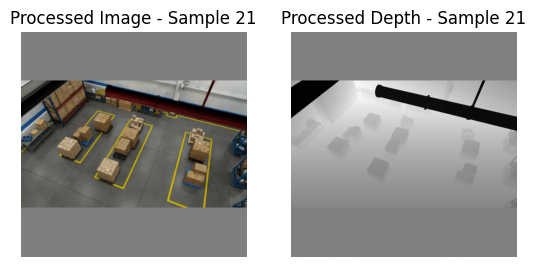

In [10]:
import random
i = random.randint(0, len(aicity_dataset))
sample_data_dict = aicity_dataset[i]

tensor = sample_data_dict['image'][0].clone().cpu().float() # Work with a float copy on CPU
mean = image_processor.image_mean
std = image_processor.image_std
for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m) # (tensor * std) + mean
tensor = tensor * 255.0
tensor = torch.clamp(tensor, 0, 255)
print(tensor.shape)
tensor = tensor.numpy().astype(np.uint8).transpose(1, 2, 0)

depth_to_show = sample_data_dict['depth'][0].cpu().numpy().transpose(1, 2, 0)
# Assuming it's normalized to [0,1] by processor, or you might need to denormalize
# If it became 3-channel by duplicating, take one channel or average
if depth_to_show.shape[2] == 3:
    depth_to_show = depth_to_show[:, :, 0] 
plt.subplot(1, 2, 1)
plt.imshow(tensor)
plt.title(f"Processed Image - Sample {i}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_to_show, cmap='gray')
plt.title(f"Processed Depth - Sample {i}")
plt.axis('off')

plt.show()

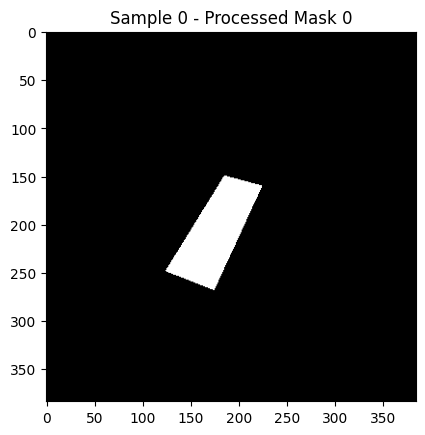

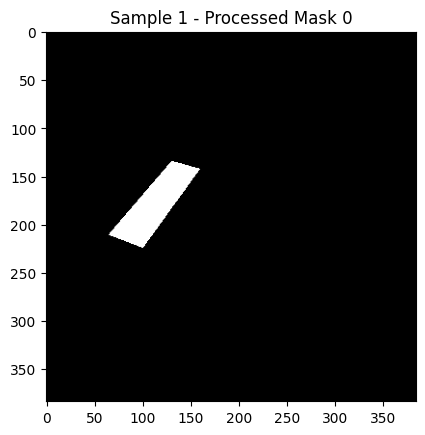

In [11]:
# Inside the loop, after loading sample_data_dict
if sample_data_dict.get('masks') is not None and sample_data_dict['masks'].nelement() > 0:
    for i in range(len(sample_data_dict['masks'])):
        first_mask_tensor = sample_data_dict['masks'][i] # Shape [H_proc, W_proc]
        plt.imshow(first_mask_tensor.cpu().numpy(), cmap='gray')
        plt.title(f"Sample {i} - Processed Mask 0")
        plt.show()


======= Visualizing Sample Index: 3 =======

--- Part A: Loading and Visualizing Raw Data from Files ---
Raw RGB loaded: PhysicalAI-Spatial-Intelligence-Warehouse/train_sample/images/021447.png
Raw Depth loaded: PhysicalAI-Spatial-Intelligence-Warehouse/train_sample/depths/021447_depth.png (Mode: L)


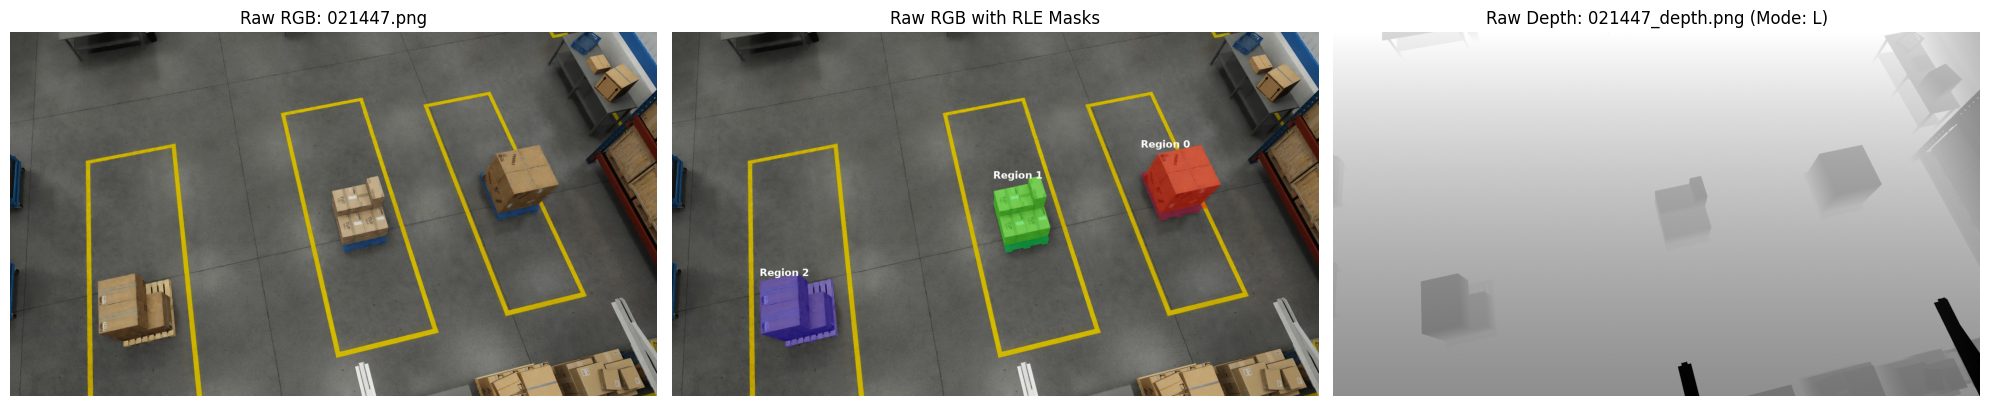


--- Part B: Loading and Visualizing Processed Data from Dataset ---


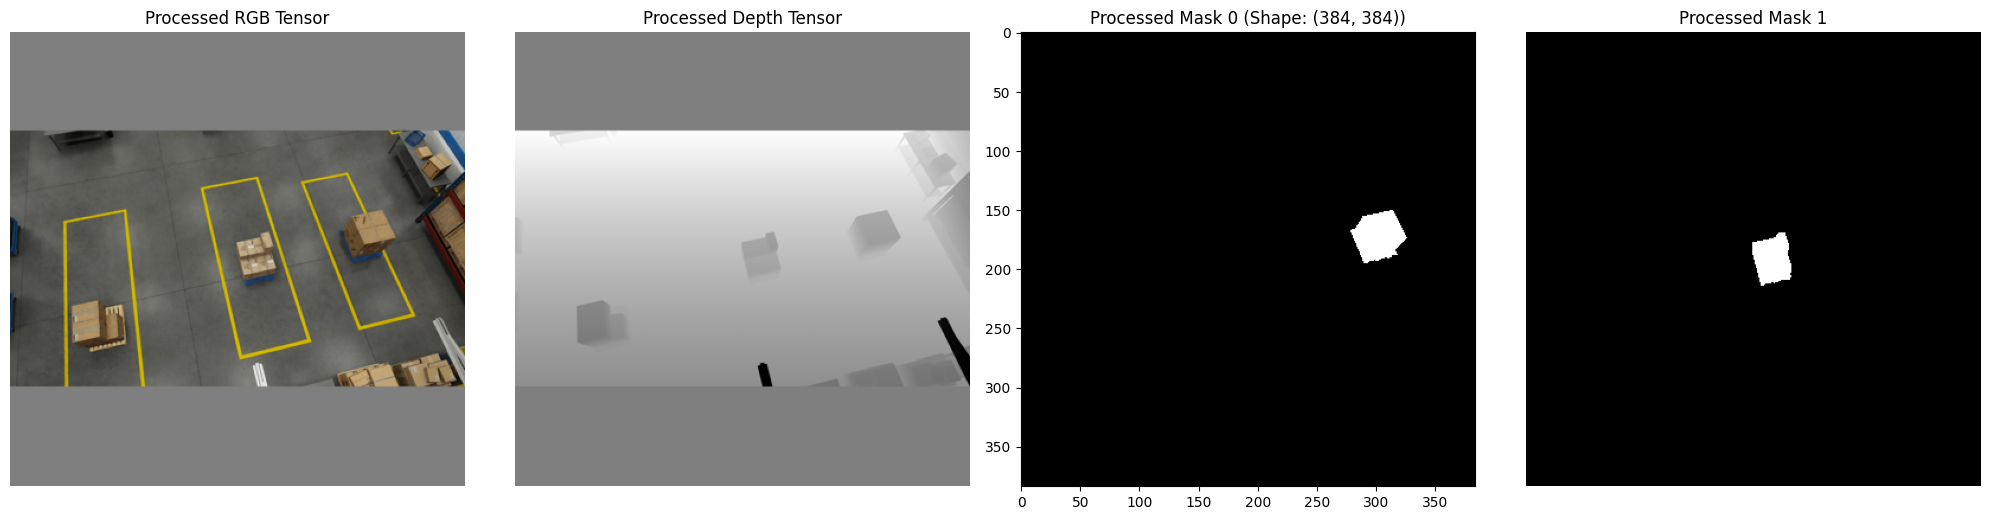


  --- Processed Textual Data ---
  Input IDs (Shape): torch.Size([92])
  Decoded Input IDs (Processed by Dataset):
    'A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: 
Among the pallet , the pallet , and the pallet , which one is the leftmost object from the image's perspective? ASSISTANT: The pallet [Region 2] is the leftmost object from this viewpoint.</s>...'
  Decoded Labels (Assistant's part):
    '...'


In [12]:

import torch
import os
import sys
import json
from PIL import Image, ImageDraw, ImageFont # Added ImageDraw for overlaying masks
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as cocomask_utils # For RLE decoding

# --- Ensure SPATIAL_RGPT_REPO_ROOT is set correctly for imports ---
# Example: SPATIAL_RGPT_REPO_ROOT = "./SpatialRGPT" if script is one level above
# sys.path.insert(0, os.path.abspath(SPATIAL_RGPT_REPO_ROOT))
# Ensure imports from previous script are available:
# from llava.train.args import DataArguments
# from llava.model.builder import load_pretrained_model
# from llava.data.aicity_dataset import AICityLazySpatialDataset
# from llava.constants import IGNORE_INDEX, DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
# from llava.mm_utils import get_model_name_from_path
# from llava.train.transformer_normalize_monkey_patch import patch_normalize_preprocess

# Assuming these are already loaded and configured from your previous test script:
# tokenizer, image_processor, data_args, aicity_dataset
# If not, include the setup code from `test_aicity_dataset_local.py` here.

# --- Helper Functions for Visualization ---

def denormalize_image_tensor(tensor, mean, std):
    """Denormalizes a torch tensor (C, H, W) image."""
    tensor = tensor.clone().cpu().float() # Work with a float copy on CPU
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) # (tensor * std) + mean
    tensor = tensor * 255.0
    tensor = torch.clamp(tensor, 0, 255)
    return tensor.numpy().astype(np.uint8).transpose(1, 2, 0) # H, W, C

def tensor_to_pil(tensor, image_processor_for_stats=None):
    """Converts a processed image tensor back to a PIL Image."""
    if tensor.ndim == 4 and tensor.shape[0] == 1: # Remove batch dim
        tensor = tensor.squeeze(0)
    if tensor.ndim != 3 or tensor.shape[0] != 3: # Expects [C, H, W]
        raise ValueError(f"Input tensor must be [C, H, W] or [1, C, H, W], got {tensor.shape}")

    if image_processor_for_stats:
        # Use mean/std from the processor used for normalization
        mean = image_processor_for_stats.image_mean
        std = image_processor_for_stats.image_std
        np_img = denormalize_image_tensor(tensor, mean, std)
    else:
        # Basic un-normalization if processor stats are not available (less accurate)
        np_img = tensor.mul(255).clamp(0, 255).byte().cpu().numpy().transpose(1, 2, 0)
    
    try:
        return Image.fromarray(np_img)
    except Exception as e:
        print(f"Error converting tensor to PIL: {e}")
        print(f"Numpy array details: shape={np_img.shape}, dtype={np_img.dtype}, min={np_img.min()}, max={np_img.max()}")
        # Fallback: try to create from the first channel if it's a grayscale visualized as RGB
        if np_img.shape[2] == 3:
            try:
                print("Trying to convert from first channel as grayscale.")
                return Image.fromarray(np_img[:,:,0], mode='L').convert('RGB')
            except: pass
        return None


def decode_rle_to_binary_mask(rle_obj):
    """Decodes a COCO-style RLE to a binary mask."""
    if not rle_obj: return None
    # Ensure counts is bytes if pycocotools < 2.0.6 expects it
    # For pycocotools >= 2.0.6, string input for RLE counts is fine.
    # If rle_obj['counts'] is str and you have older pycocotools, encode it:
    # rle_obj_copy = rle_obj.copy()
    # if isinstance(rle_obj_copy['counts'], str):
    #    rle_obj_copy['counts'] = rle_obj_copy['counts'].encode('utf-8')
    # binary_mask = cocomask_utils.decode(rle_obj_copy)
    binary_mask = cocomask_utils.decode(rle_obj)
    return binary_mask.astype(np.uint8)

def overlay_masks_on_image(image_pil, rle_list):
    """Overlays masks from RLE list onto a PIL image."""
    if not rle_list or image_pil is None:
        return image_pil

    overlay_image = image_pil.copy().convert("RGBA")
    
    colors = [(255,0,0,100), (0,255,0,100), (0,0,255,100), 
              (255,255,0,100), (0,255,255,100), (255,0,255,100)] # RGBA for transparency

    for i, rle_obj in enumerate(rle_list):
        binary_mask = decode_rle_to_binary_mask(rle_obj)
        if binary_mask is not None:
            # Ensure mask is HxW
            if binary_mask.ndim == 3 and binary_mask.shape[-1] == 1: # Handle (H,W,1) if decode gives that
                binary_mask = binary_mask.squeeze(-1)
            if binary_mask.ndim != 2:
                print(f"Warning: Decoded RLE mask {i} has unexpected ndim: {binary_mask.ndim}. Skipping.")
                continue

            # Create a colored mask image
            color = colors[i % len(colors)]
            mask_pil = Image.fromarray(binary_mask * 255, mode='L') # Create alpha mask
            
            # Create an image with the color for this mask
            colored_region = Image.new("RGBA", overlay_image.size, (0,0,0,0))
            draw = ImageDraw.Draw(colored_region)
            
            # This is a simple way to color; for more complex shapes, direct pixel manipulation might be better
            # or use mask_pil as alpha for a solid color layer.
            # For now, let's color the mask region directly.
            # This creates a colored silhouette.
            for y in range(binary_mask.shape[0]):
                for x in range(binary_mask.shape[1]):
                    if binary_mask[y, x] == 1:
                        draw.point((x, y), fill=color)
            
            overlay_image = Image.alpha_composite(overlay_image, colored_region)
            
            # Optional: Draw text for region index
            try:
                # font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf" 
                font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 30) # Ensure font is available
            except IOError:
                font = ImageFont.load_default()
            draw_overlay = ImageDraw.Draw(overlay_image)
            # Find a point to draw text (e.g., centroid or top-left of mask)
            ys, xs = np.where(binary_mask == 1)
            if len(ys) > 0:
                text_pos = (xs.min(), ys.min() - 20 if ys.min() > 20 else ys.min())
                draw_overlay.text(text_pos, f"Region {i}", fill=(255,255,255,255), font=font)

    return overlay_image.convert("RGB")


# (Keep your robust_decode_local function here)
def robust_decode_local(tokenizer, token_ids_tensor):
    IMAGE_TOKEN_INDEX = -200
    if token_ids_tensor.ndim > 1: token_ids_tensor = token_ids_tensor.squeeze(0)
    cloned_ids_list = token_ids_tensor.clone().tolist()
    final_ids_for_decode = []
    for token_id in cloned_ids_list:
        if token_id == IMAGE_TOKEN_INDEX: 
            final_ids_for_decode.append(tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
        elif token_id < 0 and token_id != IGNORE_INDEX: 
            final_ids_for_decode.append(tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0)
        else: final_ids_for_decode.append(token_id)
    return tokenizer.decode(final_ids_for_decode, skip_special_tokens=True)


# --- Main Visualization Logic ---
# Ensure `aicity_dataset`, `tokenizer`, and `image_processor` are loaded and configured
# from your main test script.
# Ensure `RGB_IMAGE_BASE_DIR` and `DEPTH_IMAGE_BASE_DIR` are correctly set.

if 'aicity_dataset' in locals() and aicity_dataset is not None and len(aicity_dataset) > 0:
    SAMPLE_INDEX_TO_VISUALIZE = random.randint(0, len(aicity_dataset)) # Choose a sample index
    if SAMPLE_INDEX_TO_VISUALIZE >= len(aicity_dataset):
        print(f"Sample index {SAMPLE_INDEX_TO_VISUALIZE} is out of bounds for dataset of length {len(aicity_dataset)}")
    else:
        print(f"\n======= Visualizing Sample Index: {SAMPLE_INDEX_TO_VISUALIZE} =======")
        
        # --- A. Visualize Raw Data from Files ---
        print("\n--- Part A: Loading and Visualizing Raw Data from Files ---")
        original_json_sample = aicity_dataset.list_data_dict[SAMPLE_INDEX_TO_VISUALIZE]
        img_base_fn = original_json_sample.get('image_base_filename')
        
        raw_rgb_pil = None
        raw_depth_pil = None
        raw_rle_list = original_json_sample.get('rle', [])

        if img_base_fn:
            # Load Raw RGB
            raw_rgb_path = os.path.join(RGB_IMAGE_BASE_DIR, img_base_fn + ".png") # Assuming .png
            try:
                raw_rgb_pil = Image.open(raw_rgb_path).convert("RGB")
                print(f"Raw RGB loaded: {raw_rgb_path}")
            except Exception as e:
                print(f"Error loading raw RGB {raw_rgb_path}: {e}")

            # Load Raw Depth
            raw_depth_path = os.path.join(DEPTH_IMAGE_BASE_DIR, img_base_fn + "_depth.png")
            try:
                raw_depth_pil = Image.open(raw_depth_path) # Load as is, likely 'L' or 'I' mode
                print(f"Raw Depth loaded: {raw_depth_path} (Mode: {raw_depth_pil.mode})")
            except Exception as e:
                print(f"Error loading raw Depth {raw_depth_path}: {e}")
        
            # Display Raw RGB, RGB with RLE overlay, Raw Depth
            fig, axs = plt.subplots(1, 3, figsize=(20, 7))
            
            if raw_rgb_pil:
                axs[0].imshow(raw_rgb_pil)
                axs[0].set_title(f"Raw RGB: {img_base_fn}.png")
                axs[0].axis('off')

                rgb_with_rle_overlay = overlay_masks_on_image(raw_rgb_pil, raw_rle_list)
                axs[1].imshow(rgb_with_rle_overlay)
                axs[1].set_title("Raw RGB with RLE Masks")
                axs[1].axis('off')
            else:
                axs[0].text(0.5, 0.5, 'Raw RGB Not Loaded', ha='center', va='center')
                axs[1].text(0.5, 0.5, 'Overlay Not Possible', ha='center', va='center')
                axs[0].axis('off'); axs[1].axis('off')


            if raw_depth_pil:
                axs[2].imshow(np.array(raw_depth_pil), cmap='gray') # Display raw depth as grayscale
                axs[2].set_title(f"Raw Depth: {img_base_fn}_depth.png (Mode: {raw_depth_pil.mode})")
                axs[2].axis('off')
            else:
                axs[2].text(0.5, 0.5, 'Raw Depth Not Loaded', ha='center', va='center')
                axs[2].axis('off')
            
            plt.tight_layout()
            plt.show()

        else:
            print("Could not get image_base_filename for raw data visualization.")

        # --- B. Visualize Processed Data from AICityLazySpatialDataset ---
        print("\n--- Part B: Loading and Visualizing Processed Data from Dataset ---")
        try:
            processed_sample_dict = aicity_dataset[SAMPLE_INDEX_TO_VISUALIZE]

            # Display Processed RGB and Depth Tensors
            fig_proc, axs_proc = plt.subplots(1, 4, figsize=(20, 7)) # RGB, Depth, First Mask

            # Processed RGB
            if processed_sample_dict.get('image') is not None:
                processed_rgb_pil = tensor_to_pil(processed_sample_dict['image'], image_processor)
                if processed_rgb_pil:
                    axs_proc[0].imshow(processed_rgb_pil)
                    axs_proc[0].set_title("Processed RGB Tensor")
                else:
                    axs_proc[0].text(0.5, 0.5, 'Processed RGB Invalid', ha='center', va='center')
            else:
                axs_proc[0].text(0.5, 0.5, 'Processed RGB Missing', ha='center', va='center')
            axs_proc[0].axis('off')

            # Processed Depth
            if processed_sample_dict.get('depth') is not None:
                # Depth tensor is also processed by image_processor which normalizes it like an RGB image
                processed_depth_pil = tensor_to_pil(processed_sample_dict['depth'], image_processor)
                if processed_depth_pil:
                    axs_proc[1].imshow(processed_depth_pil) # It's now 3-channel, so imshow works directly
                    axs_proc[1].set_title("Processed Depth Tensor")
                else:
                    axs_proc[1].text(0.5, 0.5, 'Processed Depth Invalid', ha='center', va='center')
            else:
                axs_proc[1].text(0.5, 0.5, 'Processed Depth Missing', ha='center', va='center')
            axs_proc[1].axis('off')
            
            # Processed Mask (display first mask if available)
            first_mask_tensor = processed_sample_dict['masks'][0].cpu().numpy() # Shape [H_proc, W_proc]
            axs_proc[2].imshow(first_mask_tensor, cmap='gray')
            axs_proc[2].set_title(f"Processed Mask 0 (Shape: {first_mask_tensor.shape})")
            axs_proc[3].axis('off')
        
            axs_proc[3].imshow(processed_sample_dict['masks'][1].cpu().numpy(), cmap='gray')
            axs_proc[3].set_title("Processed Mask 1")
            axs_proc[3].axis('off')

            plt.tight_layout()
            plt.show()

            # Display Textual Data
            print("\n  --- Processed Textual Data ---")
            print(f"  Input IDs (Shape): {processed_sample_dict['input_ids'].shape}")
            decoded_input_ids = robust_decode_local(tokenizer, processed_sample_dict['input_ids'])
            print(f"  Decoded Input IDs (Processed by Dataset):\n    '{decoded_input_ids[:500]}...'")

            labels = processed_sample_dict['labels']
            valid_labels_indices = labels != IGNORE_INDEX
            valid_labels = labels[valid_labels_indices]
            decoded_valid_labels = robust_decode_local(tokenizer, valid_labels)
            print(f"  Decoded Labels (Assistant's part):\n    '{decoded_valid_labels[:300]}...'")

        except Exception as e:
            print(f"Error visualizing processed sample {SAMPLE_INDEX_TO_VISUALIZE}: {e}")
            import traceback
            traceback.print_exc()
else:
    print("Dataset 'aicity_dataset' not loaded. Please run the setup cells from your main verification script first.")

In [13]:
# --- Import the DataCollator ---
try:
    from llava.data.dataset import DataCollatorForSupervisedDataset
    print("Successfully imported DataCollatorForSupervisedDataset.")
except ImportError as e:
    print(f"ERROR: Could not import DataCollatorForSupervisedDataset: {e}")
    # sys.exit(1) # Uncomment if you want to stop the script

Successfully imported DataCollatorForSupervisedDataset.


In [14]:
if 'aicity_dataset' in locals() and aicity_dataset and len(aicity_dataset) > 0:
    # --- 5. Instantiate DataCollatorForSupervisedDataset ---
    print("\nInstantiating DataCollatorForSupervisedDataset...")
    try:
        # The collator is initialized with the tokenizer and data_args
        data_collator = DataCollatorForSupervisedDataset(
            tokenizer=tokenizer,
            data_args=data_args
        )
        print("DataCollatorForSupervisedDataset instantiated successfully.")
    except Exception as e:
        print(f"ERROR instantiating DataCollator: {e}")
        # import traceback; traceback.print_exc() # Uncomment for full traceback
        data_collator = None # Ensure it's None if instantiation fails


Instantiating DataCollatorForSupervisedDataset...
DataCollatorForSupervisedDataset instantiated successfully.


In [18]:
 # --- 6. Create a Small Batch of Samples ---
batch_size_to_test = 2 # Test with a small batch
if len(aicity_dataset) < batch_size_to_test:
    print(f"Warning: Dataset has fewer than {batch_size_to_test} samples. Testing with {len(aicity_dataset)} samples.")
    batch_size_to_test = len(aicity_dataset)

In [19]:
if batch_size_to_test > 0:
    print(f"\nCreating a batch of {batch_size_to_test} samples from aicity_dataset...")
    raw_batch_list = []
    for i in range(batch_size_to_test):
        try:
            raw_batch_list.append(aicity_dataset[i])
        except Exception as e:
            print(f"ERROR fetching sample {i} from dataset: {e}")
            # import traceback; traceback.print_exc()


Creating a batch of 2 samples from aicity_dataset...


In [20]:
if data_collator:
        # --- 6. Create a Small Batch of Samples ---
        batch_size_to_test = 2 # Test with a small batch
        if len(aicity_dataset) < batch_size_to_test:
            print(f"Warning: Dataset has fewer than {batch_size_to_test} samples. Testing with {len(aicity_dataset)} samples.")
            batch_size_to_test = len(aicity_dataset)

        if batch_size_to_test > 0:
            print(f"\nCreating a batch of {batch_size_to_test} samples from aicity_dataset...")
            raw_batch_list = []
            for i in range(batch_size_to_test):
                try:
                    raw_batch_list.append(aicity_dataset[i])
                except Exception as e:
                    print(f"ERROR fetching sample {i} from dataset: {e}")
                    # import traceback; traceback.print_exc()
            
            if len(raw_batch_list) == batch_size_to_test:
                # --- 7. Call the Collator ---
                print("\nCalling the data_collator on the batch...")
                try:
                    batch_output = data_collator(raw_batch_list)
                    print("Data collator processed the batch successfully.")

                    # --- 8. Inspect the Collated Batch Output ---
                    print("\n----------- Collated Batch Output Inspection -----------")
                    print("Batch Keys:", batch_output.keys())

                    for key, value in batch_output.items():
                        print(f"\n--- Key: '{key}' ---")
                        if isinstance(value, torch.Tensor):
                            print(f"  Shape: {value.shape}, Dtype: {value.dtype}, Device: {value.device}")
                            if value.numel() > 0 and key in ['input_ids', 'labels']: # Print some token IDs
                                print(f"  Tensor values (first sample, up to 10 tokens): {value[0, :10]}")
                        elif isinstance(value, list):
                            print(f"  Type: List, Length: {len(value)}")
                            if len(value) > 0 and isinstance(value[0], torch.Tensor):
                                print(f"  First element in list is a Tensor | Shape: {value[0].shape}, Dtype: {value[0].dtype}")
                                # If key is 'masks', it's a list of mask tensors
                                if key == 'masks':
                                    for idx, mask_tensor_in_list in enumerate(value):
                                        print(f"    Mask tensor {idx} shape: {mask_tensor_in_list.shape}")
                            elif len(value) > 0:
                                print(f"  First element type: {type(value[0])}")
                        elif value is None:
                             print(f"  Value: None")
                        else:
                            print(f"  Type: {type(value)}, Value: {value}")
                    print("----------------------------------------------------")

                except Exception as e:
                    print(f"ERROR calling data_collator or inspecting output: {e}")
                    # import traceback; traceback.print_exc()
            else:
                print("Could not form a batch to test collator.")
        else:
            print("Not enough samples in dataset to form a batch for collator test.")
else:
    print("Prerequisite 'aicity_dataset' not available or empty. Skipping DataCollator check.")



Creating a batch of 2 samples from aicity_dataset...

Calling the data_collator on the batch...
Data collator processed the batch successfully.

----------- Collated Batch Output Inspection -----------
Batch Keys: dict_keys(['input_ids', 'labels', 'attention_mask', 'images', 'depths', 'masks'])

--- Key: 'input_ids' ---
  Shape: torch.Size([2, 140]), Dtype: torch.int64, Device: cpu
  Tensor values (first sample, up to 10 tokens): tensor([128000,     32,   6369,   1990,    264,  22999,   1217,    323,    459,
         21075])

--- Key: 'labels' ---
  Shape: torch.Size([2, 140]), Dtype: torch.int64, Device: cpu
  Tensor values (first sample, up to 10 tokens): tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100])

--- Key: 'attention_mask' ---
  Shape: torch.Size([2, 140]), Dtype: torch.bool, Device: cpu

--- Key: 'images' ---
  Shape: torch.Size([2, 3, 384, 384]), Dtype: torch.float32, Device: cpu

--- Key: 'depths' ---
  Shape: torch.Size([2, 3, 384, 384]), Dtype: torch.